In [1]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import access_br_dwgd as access_br_dwgd
import sys, os
sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm


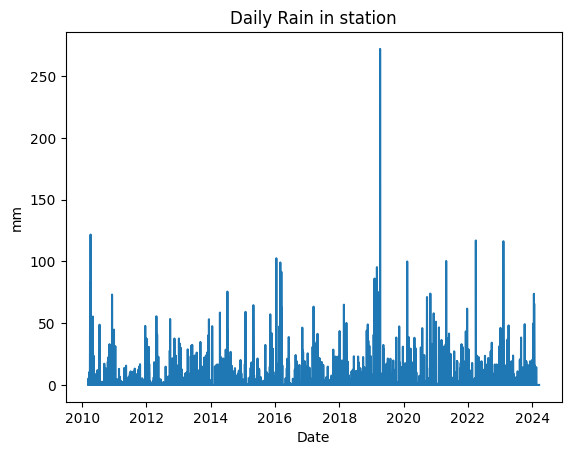

In [ ]:
timeseries = access_br_dwgd.recuperar_dados_br_dwgd_com_area()
datas = timeseries.index 
plt.plot(timeseries)
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()


In [3]:
lookback = 30
#X_train, y_train = lstm.create_dataset(train, lookback=lookback)
#X_test, y_test = lstm.create_dataset(test, lookback=lookback)

X, y = lstm.create_sequences_pytorch(timeseries, lookback=lookback)
train_size = int(len(timeseries) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = datas[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]



/home/pbose/tcc/pesquisa/utils/lstm.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = input_data[i+lookback]


In [4]:

model = LstmModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=20)

In [5]:
n_epochs = 10

# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# --- Bloco de Avaliação Final (executado apenas uma vez) ---
print("\nTreinamento finalizado. Calculando o RMSE final...")
model.eval()  # modo avaliação
with torch.no_grad():
    # Previsões no conjunto de teste
    y_pred_test = model(X_test)
    
    # Se for LSTM com saída 2D (batch, 1), transforma para 1D
    y_pred_np = y_pred_test.detach().cpu().numpy().flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten()
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    
    # MSE
    mse = mean_squared_error(y_test_np, y_pred_np)
    
    # MAE
    mae = mean_absolute_error(y_test_np, y_pred_np)
    
print(f"Conjunto de Teste:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


# --- Novo Bloco para Imprimir Previsto vs. Esperado ---
print("\n--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---")
model.eval()
with torch.no_grad():
    # Pega as previsões finais do conjunto de teste
    y_pred_final = model(X_test)
    valores_previstos = y_pred_final.detach().cpu().numpy()
    valores_esperados = y_test.detach().cpu().numpy()

    # Itera sobre os 10 primeiros exemplos e imprime lado a lado
    for i in range(10):
        previsto = valores_previstos[i][0]
        esperado = valores_esperados[i][0]
        print(f"Exemplo {i+1}: Previsto = {previsto}, Esperado = {esperado}")


Treinamento finalizado. Calculando o RMSE final...
Conjunto de Teste:
RMSE: 9.6034
MSE: 92.2254
MAE: 4.5091

--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---
Exemplo 1: Previsto = 1.8530457019805908, Esperado = 0.0
Exemplo 2: Previsto = 1.8525654077529907, Esperado = 0.0
Exemplo 3: Previsto = 1.853419542312622, Esperado = 0.0
Exemplo 4: Previsto = 1.8547389507293701, Esperado = 17.600000381469727
Exemplo 5: Previsto = 7.411509037017822, Esperado = 0.4000000059604645
Exemplo 6: Previsto = 3.7356579303741455, Esperado = 0.0
Exemplo 7: Previsto = 0.8930946588516235, Esperado = 0.0
Exemplo 8: Previsto = 2.8285844326019287, Esperado = 0.0
Exemplo 9: Previsto = 2.3561670780181885, Esperado = 100.0
Exemplo 10: Previsto = 7.9688310623168945, Esperado = 16.600000381469727


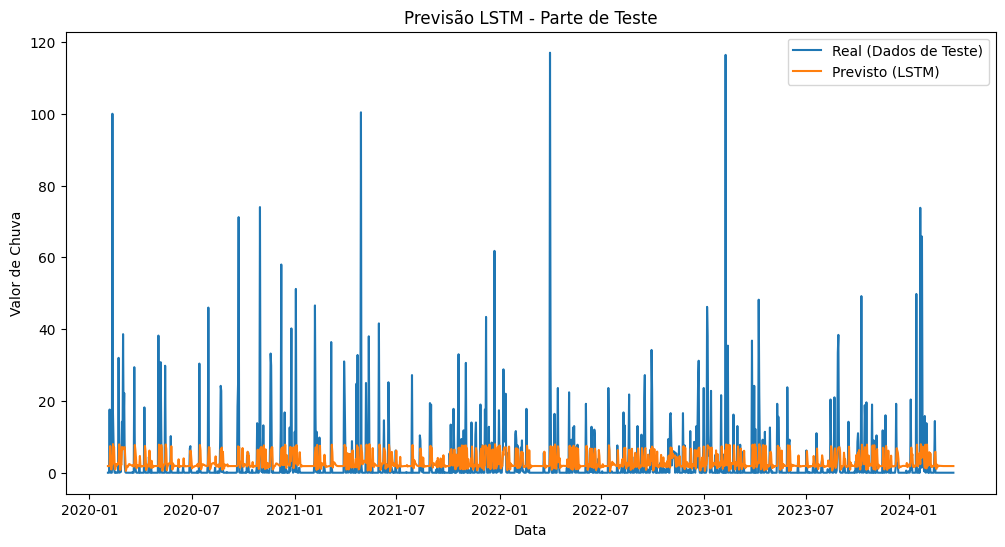

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(test_date, y_test_np, label="Real (Dados de Teste)")
plt.plot(test_date, y_pred_np, label="Previsto (LSTM)")
plt.title("Previsão LSTM - Parte de Teste")
plt.xlabel("Data")
plt.ylabel("Valor de Chuva")
plt.legend()
plt.show()